In [1]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
figformat = 'svg'

In [3]:
dataset_asimov = Dataset_load.create_asimov()

In [4]:
biass = [0.0]
biass_assumed = 0.1
sigmass = [0.0]
sigma_assumed = 1e-12

shift = 0.0 
shift_assumed = 0.1


In [5]:
b = biass[0]; s = sigmass[0]

sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                    shift = shift,
                    tilt = 0,
                    bias = b, 
                    resolution = s,
                    rnd = False,
                    e_reco_creation=10)
dataset_conv = sys_d_cor.create_dataset()
dataset_conv_N = sys_d_cor.create_dataset_N(10)
dataset_conv_N.models.parameters['resolution'].frozen  = True
dataset_conv_N.e_reco_n = 10
# new fine binned IRF Model

zero = 1e-12
penalising_invcovmatrix = np.zeros((4,4))
if b ==0 :
    b_ = zero
else:
    b_ = b
np.fill_diagonal(penalising_invcovmatrix, [1/biass_assumed**2, 1/zero**2, 1/shift_assumed**2, 1/zero**2])
dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets_conv = Datasets([dataset_conv])
datasets_conv_N = Datasets([dataset_conv_N])




compute exposure
compute edisp
0.0
compute exposure
compute edisp
0.0


In [6]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_asimov.geoms['geom'].axes[0]

In [7]:
print(dataset_conv_N)

compute edisp
0.0
compute exposure
compute edisp
0.0
compute exposure
compute edisp
0.0
compute exposure
MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361331.59
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1000.25

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 3 
  Number of parameters            : 16
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel

compute edisp
0.0
compute exposure


<WCSAxesSubplot: >

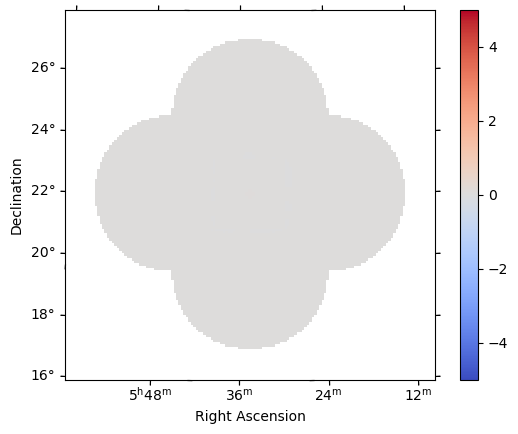

In [8]:
d = dataset_conv_N
d.plot_residuals_spatial()

compute edisp
0.0
compute exposure


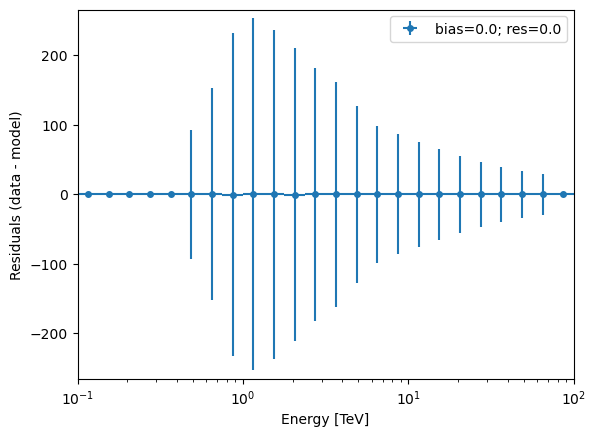

In [9]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


compute edisp
0.0
compute exposure
compute edisp
0.0
compute exposure


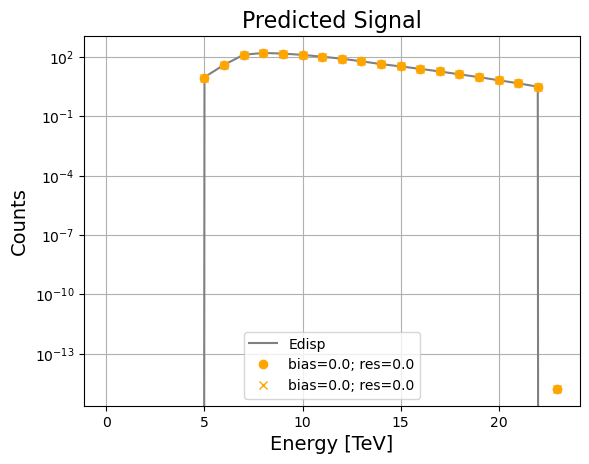

In [10]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(sum_e(dataset_asimov.counts.data-dataset_asimov.background.data),
         label = "Edisp", color = 'grey')
npreds_pre_fit = []
npreds_pre_fit_N = []
for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        
        plt.plot( sum_e(datasets_conv[i].npred_signal().data),
                 fmts[i], label = f"bias={b}; res={s}", color = colors[i])
        plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
                 'x', label = f"bias={b}; res={s}", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.yscale('log')
plt.legend()
plt.xlabel("Energy [TeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.grid(True)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)

In [11]:
print(datasets_conv_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.00 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Paramet

In [12]:
%%time
fitting = False

if fitting:

    print("corr")
    for d in datasets_conv:
        fit_cor = Fit(store_trace=True)
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run(d)
        d.models.covariance = fit_cor.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor.minuit)

    for d in datasets_conv_N:
        fit_cor_N = Fit(store_trace=True)
        fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
        result_cor_N = fit_cor_N.run(d)
        d.models.covariance = fit_cor_N.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor_N.minuit)
    
    print("saving")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_{biass[0]}_sigma_{sigmass[0]}.yml'
        d.models.write(path,overwrite=True)
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_{biass[0]}_sigma_{sigmass[0]}.yml'
        d.models.write(path,overwrite=True)
        
else:
    print("read")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_{biass[0]}_sigma_{sigmass[0]}.yml'
        datasets_conv[i] = Dataset_load.load_dataset_N(d, path)        
    print("read nui")
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_{biass[0]}_sigma_{sigmass[0]}.yml'
        datasets_conv_N[i] = Dataset_load.load_dataset_N(d, path)        
        
    



read
read nui
CPU times: user 115 ms, sys: 9.02 ms, total: 124 ms
Wall time: 124 ms


In [13]:
colors_standard = ['darkblue', 'sienna', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


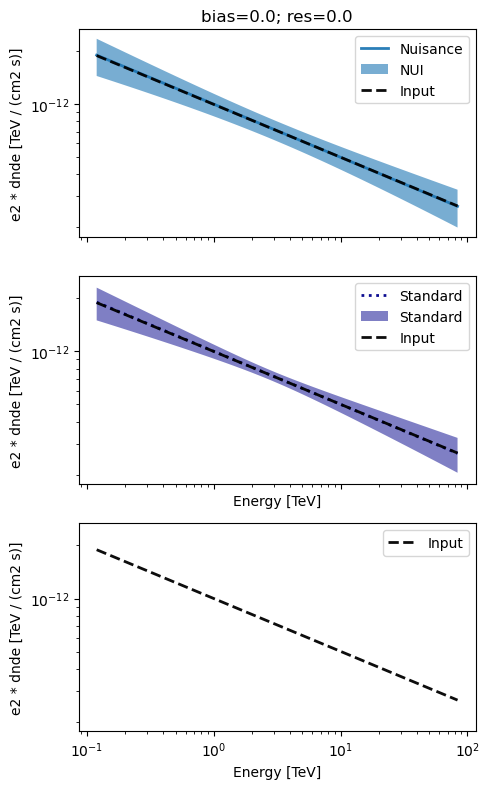

In [14]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV


fig,axs = plt.subplots(3,1, sharex = True, sharey=True, figsize = (5,8))
#axs = [axs]
i =0; ii =0
for b in biass:
    for s in sigmass:
        
        d = datasets_conv_N
    
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               color=colors[ii],
                                                                 label= f"Nuisance",
                                                                alpha = 0.95,
                                                               linestyle='-', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii],
                                                               facecolor=colors[ii],
                                                                 label="NUI",
                                                                alpha = 0.6)
        d = datasets_conv
        d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               color=colors_standard[ii],
                                                                 label= f"Standard",
                                                                alpha = 0.95,
                                                               linestyle=':', linewidth= 2)       

        d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[ii+1],
                                                               facecolor=colors_standard[ii],
                                                                 label="Standard",
                                                                alpha = 0.5)
        
        
        axs[ii].set_title(f"bias={b}; res={s}")
        i +=1
        ii +=1
for a in axs:
    dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                               color='black',
                                                                 label="Input",
                                                                alpha = 0.95,
                                                               linestyle='dashed', linewidth= 2)  
    a.legend()
    
ylim = axs[0].get_ylim()
axs[0].set_xlabel('')
plt.tight_layout()


compute edisp
-1.2767088447503074e-11
compute exposure


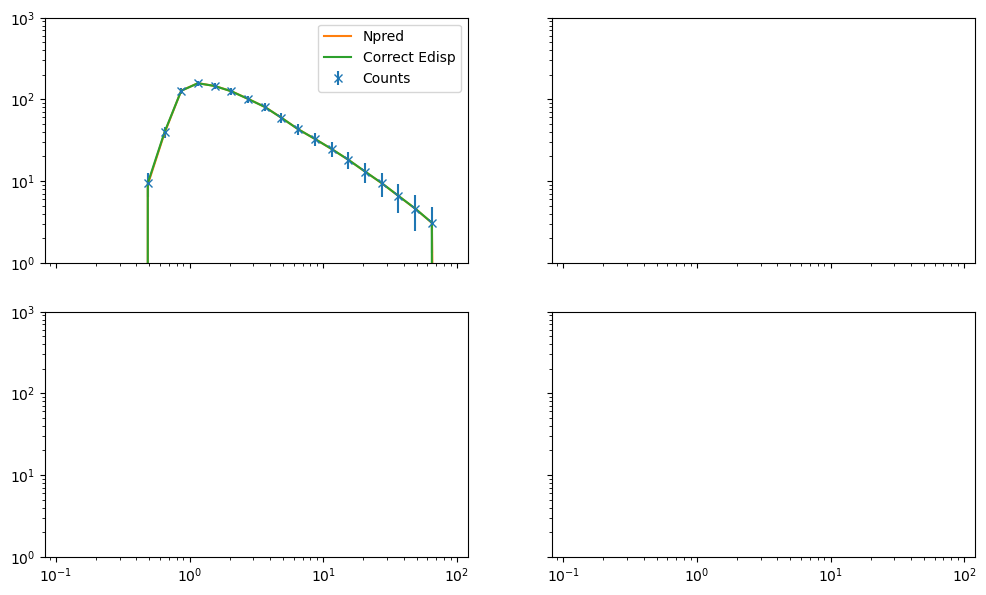

In [15]:
fig,axs = plt.subplots(2,2, sharex = True, sharey=True, figsize = (12,7))
axs = axs.flatten()
i =0; ii =0
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        axs[ii].errorbar(energy, sum_e(d.counts.data-d.background.data), 
                     yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
                    fmt = 'x', label = "Counts")

        axs[ii].plot(energy, sum_e(d.npred_signal().data), label = "Npred")
        axs[ii].plot(energy, sum_e(dataset_asimov.npred_signal().data), label = "Correct Edisp")
        
        
        
        axs[ii].loglog()
        axs[ii].legend()
        axs[ii].set_ylim(1e0, 1e3)        
        ii +=1
        


compute edisp
-1.2767088447503074e-11
compute exposure


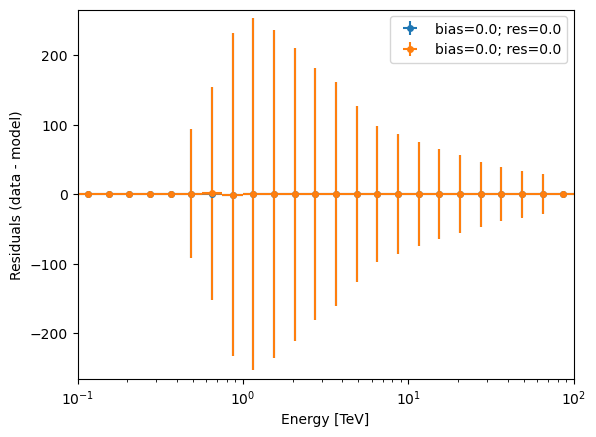

In [16]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        d = datasets_conv[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i+1], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()


In [17]:
import json
with open("../config.json") as json_data_file:
    config = json.load(json_data_file)
config['local']['path']

'/home/katrin/Documents'

In [18]:
path = config['local']['path']+f'/nuisance_summary/E_reco/Bias/data/2_model_nui_{biass[0]}_sigma_{0.0}.yml'
dataset_ereco = sys_d_cor.create_dataset_N(10)
dataset_ereco = Dataset_load.load_dataset_N(dataset_ereco, path)

path = config['local']['path']+f'/nuisance_summary/Eff_area/data/2_model_nui_{shift}_tilt_{0}.yml'
dataset_effarea = sys_d_cor.create_dataset_N(10)
dataset_effarea = Dataset_load.load_dataset_N(dataset_effarea, path)

compute exposure
compute edisp
0.0
norm_nuisance not found
tilt_nuisance not found
compute exposure
compute edisp
0.0


In [19]:
print(dataset_effarea.models)

DatasetModels

Component 0: SkyModel

  Name                      : e2vW-rGT
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.06             
    amplitude                     :   1.00e-12   +/- 1.5e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: IRFModels

  Name                      : T1WUBfHb-irf
  Datasets names            : T1WUBfHb
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffA

['Standard', 'Ereco + \nEff Area', 'Ereco', 'Eff']


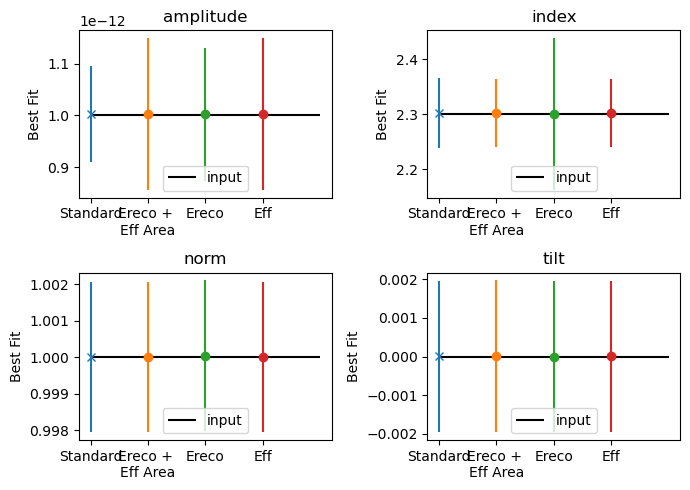

In [20]:
fig,ax  = plt.subplots(2,2,figsize= (7, 5))
ax = ax.flatten()
parnames = ['amplitude', 'index', 'norm', 'tilt']
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x', )
        labels_sys.append(f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(1, value, yerr = error, fmt = 'o', )
        labels_sys.append(f'Ereco + \nEff Area')
            
            
        d = dataset_ereco
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(2, value, yerr = error, fmt = 'o', )
        labels_sys.append(f'Ereco')
        
        d = dataset_effarea
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(3, value, yerr = error, fmt = 'o', )
        labels_sys.append(f'Eff')
            
            
        ii +=1
print(labels_sys)        
for i, p in enumerate(parnames):
    value = dataset_asimov.models.parameters[p].value
    error = dataset_asimov.models.parameters[p].error    
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys), label = "input", color= 'black')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    
plt.tight_layout()
    

In [26]:
print(dataset_ereco.models)

DatasetModels

Component 0: SkyModel

  Name                      : nWbt-arU
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.14             
    amplitude                     :   1.00e-12   +/- 1.3e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: IRFModels

  Name                      : bA6oJIiO-irf
  Datasets names            : bA6oJIiO
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffA

In [21]:
print(dataset_effarea.models)

DatasetModels

Component 0: SkyModel

  Name                      : e2vW-rGT
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.06             
    amplitude                     :   1.00e-12   +/- 1.5e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.019   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: IRFModels

  Name                      : T1WUBfHb-irf
  Datasets names            : T1WUBfHb
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffA

['both', 'ereco', 'effarea']


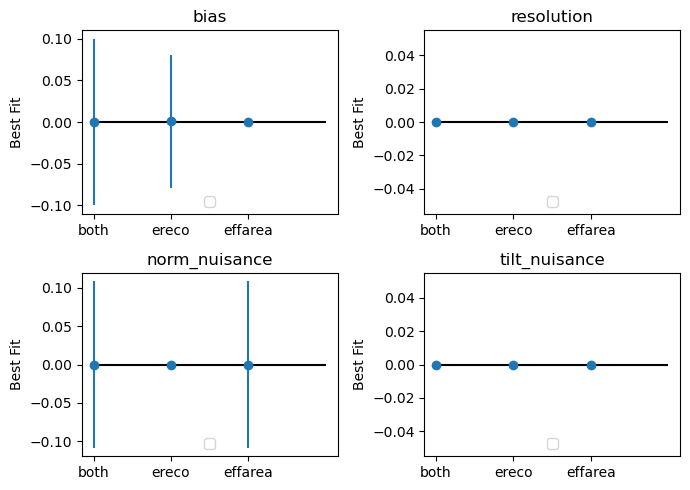

In [22]:
fig,ax  = plt.subplots(2,2,figsize= (7, 5))
ax = ax.flatten()
parnames = dataset_conv_N.models.parameters.penalised_parameters.names
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        datasets = [datasets_conv_N[0], dataset_ereco, dataset_effarea]
        for k, d in enumerate(datasets):
            for i, p in enumerate(parnames):
                try:
                    value = d.models.parameters[p].value
                    error = d.models.parameters[p].error    
                    ax[i].errorbar(k, value, yerr = error, fmt = 'o', color = colors[ii])
                    ax[i].set_title(p)
                except:
                    print(k)
            
        ii +=1
        
labels_sys = ['both', 'ereco', 'effarea']        
print(labels_sys)        
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='lower center',)# bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    #ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    ax.hlines( 0, 0., len(labels_sys), label = "input", color= 'black')
    
plt.tight_layout()
    

compute edisp
-1.2767088447503074e-11
compute exposure


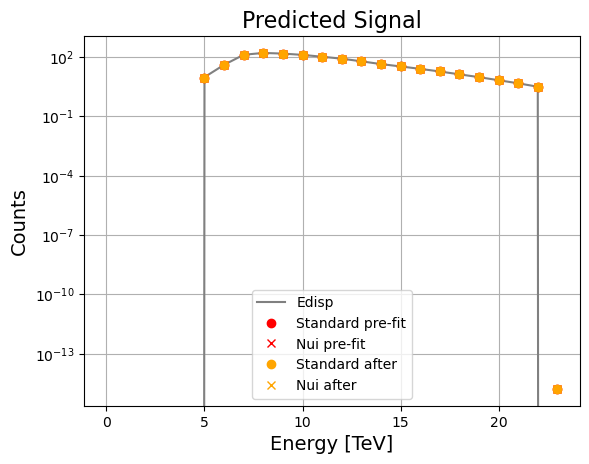

In [23]:
import matplotlib.pyplot as plt

# Your data processing code here

plt.title("Predicted Signal", fontsize=16)
i = 0 
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(sum_e(dataset_asimov.counts.data-dataset_asimov.background.data),
         label = "Edisp", color = 'grey')
for b in biass:
    for s in sigmass:
        plt.plot( npreds_pre_fit[i],
                 fmts[i], label = f"Standard pre-fit", color = colors[i+1])
        plt.plot( npreds_pre_fit_N[i],
                 'x', label = f"Nui pre-fit", color = colors[i+1])
        
        plt.plot( sum_e(datasets_conv[i].npred_signal().data),
                 fmts[i], label = f"Standard after", color = colors[i])
        plt.plot( sum_e(datasets_conv_N[i].npred_signal().data),
                 'x', label = f"Nui after", color = colors[i])
        i += 1
        
#plt.ylim(1e-1, 4e2)
plt.yscale('log')
plt.legend()
plt.xlabel("Energy [TeV]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.grid(True)
fig = plt.gcf()
#fig.savefig(f"plots/1_Npred_bias={bias}sigma={sigma}.png", dpi=300, quality=95)